# Bachelier 

# General Imports and Settings

In [4]:
!pip install jaxtyping
!pip install equinox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 6.0 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass
from functools import partial

jax.devices()

jax.enable_checks = True

In [6]:
# list requirements
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.10
equinox==0.10.4
optax==0.1.5
chex==0.1.7
tensorflow==2.12.0
tensorflow_datasets==4.9.2


In [13]:
# test: edited with colab
NUM_EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [8]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

# Standard ML

## Data generation

In [45]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

            
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3,4,5,6,7,8))
def trainingSet(n, m, T1 = 1.0, T2 = 2.0, K = 1.10, volMult = 1.5, anti=True, seed=2, bktVol=0.2):

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        print(X.shape, inc1.shape)
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if False:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)

            # # differentials
            # Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            Y = pay
            
            # # differentials
            # Z =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        return Y

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    return X, Y.reshape(-1,1), Z, ddYddX, a

# test set: returns an array of independent, uniformly random spots 
# with corresponding baskets, ground true prices, deltas and vegas
def testSet(n, a, T1 = 1.0, T2 = 2.0, K = 1.10, bktVol = 0.2, lower=0.5, upper=1.50, num=4096, seed=42):
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(num, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, a).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ a.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas    

In [46]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = True


           
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2):
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if True:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)
        # standard
        else:
            Y = pay

        return Y

    y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
    # basis = jnp.eye(y.size, dtype=y.dtype)
    # jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    jac = vjpfun(jnp.ones(y.size))[0]

    h = 1e-4
    fd_ph = func(S1 + h, inc1)
    fd_mh = func(S1 - h, inc1)
    fd = (fd_ph - fd_mh) / (2 * h)

    # def cfd(f, h):

    #     def cfd_fn(x, *args):
    #         return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

    #     return cfd_fn

    # cfd_fn = cfd(func, h)
    # cfd_fd = cfd_fn(S1, inc1)

    fdd = (fd_ph - 2 * y + fd_mh) / (h * h)

    # use finite differences to check:
    # h = 1e-4
    jac_fdd_ph = vjpfun(jnp.ones(y.size) + h)[0]
    jac_fdd_mh = vjpfun(jnp.ones(y.size) - h)[0]

    jac_fdd = (jac_fdd_ph - jac_fdd_mh) / (2 * h)

    print("jac is: ")
    print(jac.shape)

    print("y is: ")
    print(y.shape)
    print(y)
    if 0: 
        y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
        basis = jnp.eye(y.size, dtype=y.dtype)
        jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
        # return y, jac, vjpfun

        Y = y
        Z = jac

        # Y, Z = jax.vmap(value_and_jacrev(func, argnums=0))(S1, inc1)

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    print("Y is: ")
    print(Y.shape)
    print(Y)
    jax.debug.print("{val}", val=(Y - y).sum())
    print("Z is: ")
    print(Z.shape)
    jax.debug.print("Diff is: {val}", val=(Z - jac).sum())
    jax.debug.print("Example values: {val1}, {val2}", val1=Z[2,0], val2=jac[2,0])

    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    # return X, Y.reshape(-1,1), Z, ddYddX, a
    return X, y.reshape(-1,1), jac, ddYddX, a, fd, fdd, jac_fdd

def testSet(params: BachelierParams, weights, n_samples=4096, seed=42):
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas   



In [47]:
bachelier_params = BachelierParams(n_dim=1)
X, Y, Z, W, weights, fd, fdd, jac_fd = trainingSet(10 * N_TRAINING_SAMPLES, bachelier_params, seed=42)

def info(X, Y, Z, W, fd, jac_fd):
    print(X.shape)
    print(Y.shape)
    print(Z.shape)
    print(W.shape)
    print("FD")
    print(fd.shape)
    print(fd)
    print("JAC_FD")
    print(jac_fd)

# info(X, Y, Z, W, fd, jac_fd)

spots, baskets, prices, deltas, vegas = testSet(bachelier_params, weights, n_samples=10 * N_TEST_SAMPLES)
# print(spots.shape)

jac is: 
(81920, 1)
y is: 
(81920,)
Traced<ShapedArray(float32[81920])>with<DynamicJaxprTrace(level=1/0)>
Y is: 
(81920,)
Traced<ShapedArray(float32[81920])>with<DynamicJaxprTrace(level=1/0)>
Z is: 
(81920, 1)
0.0
Diff is: 0.0
Example values: 0.5, 0.5


## Plot generated Data

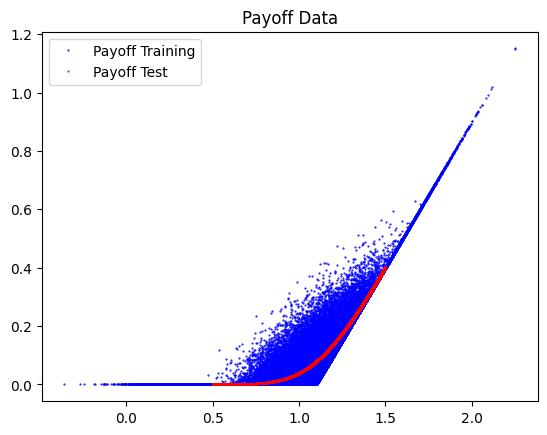

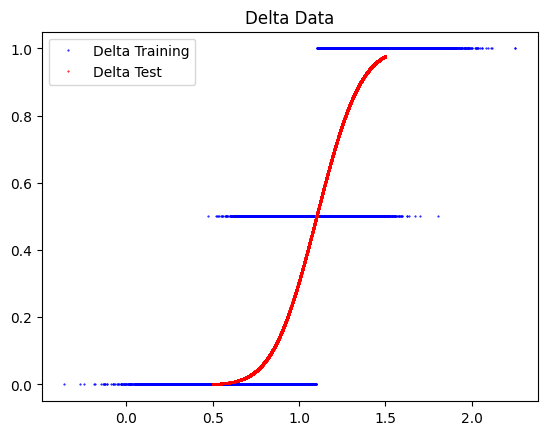

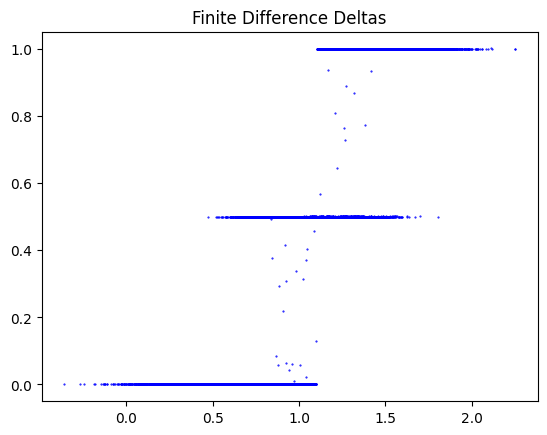

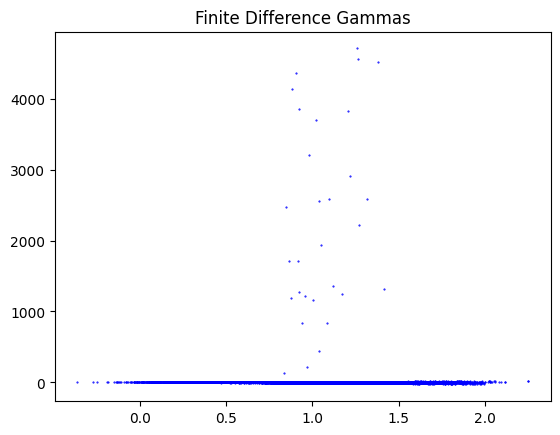

In [48]:
def plot_payoff_data(x_train, y_train, x_test, y_test):
    plt.title("Payoff Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_test, y_test, 'r.', label='Payoff Test', markersize=1)
    plt.legend()
    plt.show()

def plot_delta_data(x_train, x_test, dydx_train, dydx_test):
    plt.title("Delta Data")
    plt.plot(x_train, dydx_train, 'b.', label='Delta Training', markersize=1)
    plt.plot(x_test, dydx_test, 'r.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()

plot_payoff_data(X[:,0], Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(X[:,0], baskets[:, 0], Z[:,0], deltas[:,0])

plt.title("Finite Difference Deltas")
plt.plot(X[:,0], fd, 'b.', label='FD', markersize=1)
plt.show()

plt.title("Finite Difference Gammas")
plt.plot(X[:,0], fdd, 'b.', label='FD', markersize=1)
plt.show()

In [49]:
bachelier_params = BachelierParams(n_dim=7)
X, Y, Z, W, weights, fd, fdd, jac_fd= trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
spots, baskets, prices, deltas, vegas = testSet(bachelier_params, weights, n_samples=N_TEST_SAMPLES)

jac is: 
(8192, 7)
y is: 
(8192,)
Traced<ShapedArray(float32[8192])>with<DynamicJaxprTrace(level=1/0)>
Y is: 
(8192,)
Traced<ShapedArray(float32[8192])>with<DynamicJaxprTrace(level=1/0)>
Z is: 
(8192, 7)
0.0
Example values: 0.0, 0.0
Diff is: 0.0


In [50]:

print(X.shape)
print(baskets.shape)
print(deltas.shape)
print(Y.shape)

(8192, 7)
(4096, 1)
(4096, 7)
(8192, 1)


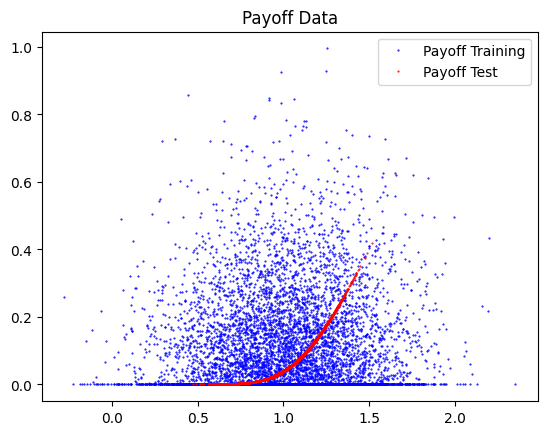

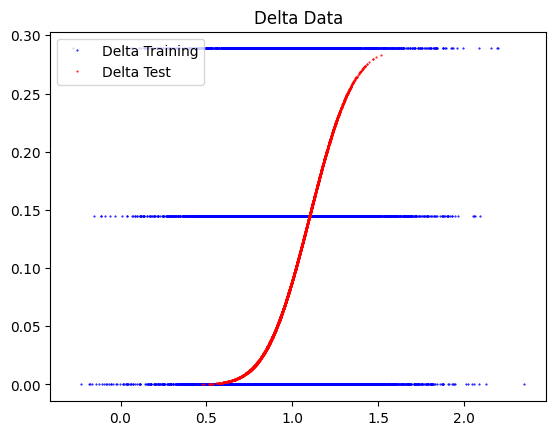

In [51]:
vis_dim = 0
plot_payoff_data(X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

## Train Standard ML

In [52]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [53]:
x_train = X
y_train = Y
dydx_train = Z

In [54]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [55]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, 
                       eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu), 
                       y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [56]:
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key)

In [57]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  # print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model


key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [58]:
def mean_squared_error(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [59]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [60]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(MakeScalar(model))(x)
    chex.assert_type([pred_y], float)
    pred_y = pred_y[:, jnp.newaxis]
    result = mean_squared_error(y, pred_y)
    chex.assert_type([result], float)
    return result

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [62]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

            if (step % 100 == 0):
                test_loss = loss_fn(model, x_test, y_test)
                # test_loss = 0
                print('Finished epoch {:3d}'.format(epoch), 
                      ' | Train Loss: {:.5f}'.format(train_loss),
                      ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [63]:
print(vmap(model)(x_train))

print(vmap(MakeScalar(model))(x_train))

[[0.1393539 ]
 [0.1447855 ]
 [0.12520188]
 ...
 [0.09687012]
 [0.24341448]
 [0.09513877]]
[0.1393539  0.1447855  0.12520188 ... 0.09687012 0.24341448 0.09513877]


In [64]:
optim = optax.adam(learning_rate)
# model = MakeScalar(model)
model = train(model, x_train, y_train, optim, n_epochs=10)

Finished epoch   0  | Train Loss: 0.02108  | Test Loss: 0.00885
Finished epoch   1  | Train Loss: 0.00169  | Test Loss: 0.00024
Finished epoch   2  | Train Loss: 0.00140  | Test Loss: 0.00005
Finished epoch   3  | Train Loss: 0.00138  | Test Loss: 0.00004
Finished epoch   4  | Train Loss: 0.00137  | Test Loss: 0.00006
Finished epoch   5  | Train Loss: 0.00138  | Test Loss: 0.00007
Finished epoch   6  | Train Loss: 0.00137  | Test Loss: 0.00007
Finished epoch   7  | Train Loss: 0.00137  | Test Loss: 0.00006
Finished epoch   8  | Train Loss: 0.00137  | Test Loss: 0.00006
Finished epoch   9  | Train Loss: 0.00136  | Test Loss: 0.00005


## Plot results

(4096, 1)
RMSE: 0.006684068124741316


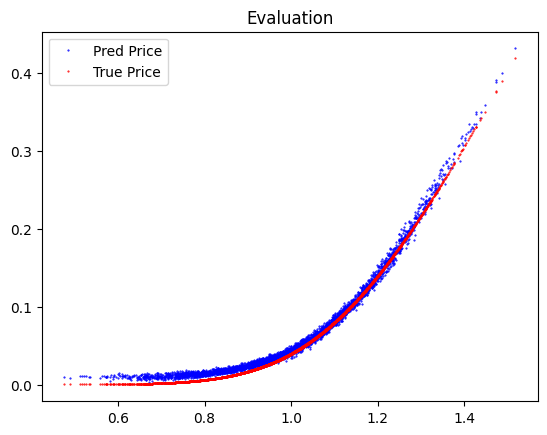

In [65]:
# scaled input
# x = (x_test - x_train_mean) / x_train_std
x = x_test

pred_y = vmap(model)(x)

# unscale predictions
# pred_y = pred_y * y_train_std + y_train_mean
print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> Float:
    return jnp.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()

RMSE: 0.006684068124741316


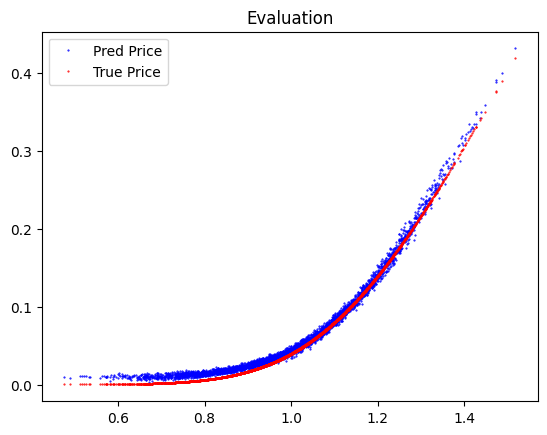

RMSE 0.007719600573182106


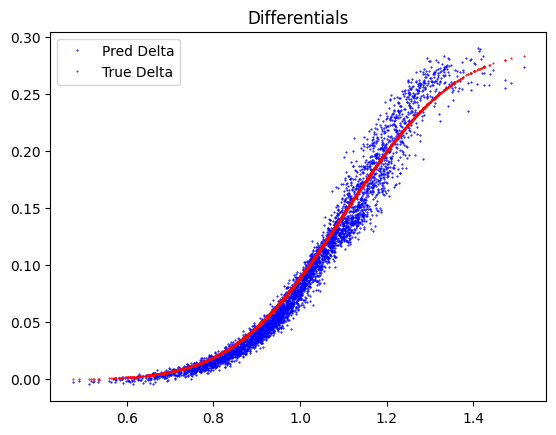

In [66]:
pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x_test)

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()

# Differential ML

## Data generation

In [67]:
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    return loss

In [68]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

In [69]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key)

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

## Train

In [71]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

            if (step % 100 == 0):
                test_loss = diff_loss_fn(model, x_test, y_test, dydx_test)
                print('Finished epoch {:3d}'.format(epoch), 
                      ' | Train Loss: {:.5f}'.format(train_loss),
                      ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [72]:
optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim, n_epochs=10)

Finished epoch   0  | Train Loss: 0.00881  | Test Loss: 0.00324
Finished epoch   1  | Train Loss: 0.00092  | Test Loss: 0.00008
Finished epoch   2  | Train Loss: 0.00086  | Test Loss: 0.00003
Finished epoch   3  | Train Loss: 0.00084  | Test Loss: 0.00003
Finished epoch   4  | Train Loss: 0.00084  | Test Loss: 0.00002
Finished epoch   5  | Train Loss: 0.00084  | Test Loss: 0.00002
Finished epoch   6  | Train Loss: 0.00084  | Test Loss: 0.00002
Finished epoch   7  | Train Loss: 0.00084  | Test Loss: 0.00002
Finished epoch   8  | Train Loss: 0.00084  | Test Loss: 0.00002
Finished epoch   9  | Train Loss: 0.00084  | Test Loss: 0.00002


## Plot results

(4096, 1)
RMSE: 0.005790088325738907


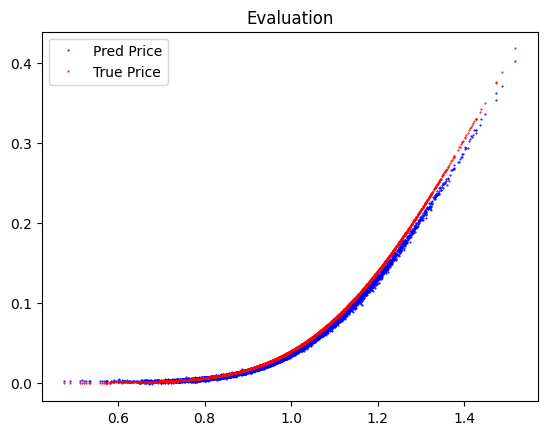

In [73]:
x = x_test

pred_y = vmap(model)(x)

# unscale predictions
# pred_y = pred_y * y_train_std + y_train_mean
print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> Float:
    return jnp.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()

RMSE: 0.005790088325738907


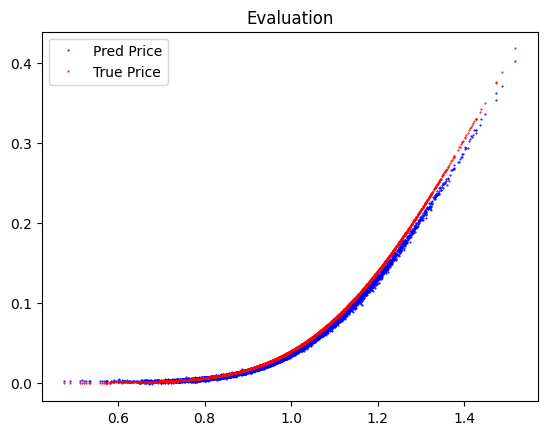

RMSE 0.004699479788541794


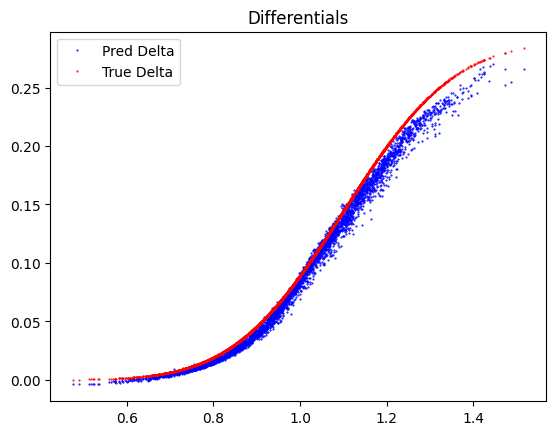

In [74]:
pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x_test)

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()

# Differential ML with PCA

## Data generation

In [75]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #.cache() #.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE) #.prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [76]:
import numpy as np

In [99]:
from enum import Enum

class dydx_type(Enum):
    Default = 1
    MeanAdjusted = 2
    PCA = 3
    PCA_Reduced = 4


def plot_singular_values(S):
    plt.title("Singular Values of Gradient")
    plt.plot(S, 'r', markersize=0)
    plt.show()


def plot_dydx_pred(x, dydx_pred, title):
   
    if title == dydx_type.Default.value:
        plt.title("Predicted Gradients of all Dimensions")
    elif title == dydx_type.MeanAdjusted.value: 
        plt.title("Predicted Gradients of all Dimensions | Mean Adjusted")
    elif title == dydx_type.PCA.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reconstruction")
    elif title == dydx_type.PCA_Reduced.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reduced")
    else:  
        plt.title("Predicted Gradients of all Dimensions")

    for i in range(dydx_pred.shape[1]):
        plt.plot(x[:, i], dydx_pred[:, i], '.', markersize=1)
    plt.show()


def plot_dydx_pred_individual_dims(x, dydx, dydx_pred, dydx_pred_pca, principle_components, pc_scaled):

    for i in range(x.shape[1]):

        plt.title(f"Differentials Dimension {i}")
        plt.plot(x[:, i], dydx[:, i], 'b.', markersize=1)
        plt.plot(x[:, i], dydx_pred[:, i], 'r.', markersize=1)
        plt.show()

        # variance within the dimesions:
        plt.title(f"Variance of Dim {i} (y-axis) w.r.t Dim 0 (x-axis))")
        plt.plot(dydx_pred_pca[:, 0], dydx_pred_pca[:, i], 'b.', markersize=1)


        colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
        for j, _ in enumerate(principle_components):
            plt.plot(np.array([0, 0 + pc_scaled[j, 0]]),
                    np.array([0,  0 + pc_scaled[j, i]]), '-', color=colors[j], linewidth=5, label=f"PC{j}")

        plt.legend()
        plt.show()


def plot_batch(x, y, y_pred):
    plt.title("Data Batch Normalized")
    plt.plot(x, y, 'b.', markersize=1)
    plt.plot(x, y_pred, 'r.', markersize=1)
    plt.show()


def diff_pca_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"], debug: bool = True) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    y_pred = y_pred[..., jnp.newaxis]
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    dydx_pred_means = jnp.mean(dydx_pred, axis=0)
    # print("dydx_pred_means.shape:", dydx_pred_means.shape)
    # print("dydx_pred_means: ", dydx_pred_means)

    dydx_pred_mean_adjusted = dydx_pred - jnp.tile(dydx_pred_means, (dydx_pred.shape[0], 1))

    U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)

    # the principle components give use the directions for the hesse vectors
    principle_components = jnp.diag(S) @ VT

    # we need the vjp_fun from eqx.filter_vjp 
    # then we can *hopefully* use eqx.filter_vjp(vjp_fun, principle_components) 
    # to get to selected hvp results. Those can then be used as part of the loss  

    if debug:
      pc_scaled = principle_components / jnp.sqrt(x.shape[0])
      dydx_pred_pca = U @ principle_components
      k_dims = 1
      dydx_pred_reduced = U[:, :k_dims] @ principle_components[:k_dims, :]

      pca_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_pca)
      jax.debug.print("pca reconstruction_err: {err}", err=pca_reconstruction_err)

      reduced_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_reduced)
      jax.debug.print("reduced ({dim} dims) reconstruction_err: {err}", dim=k_dims, err=reduced_reconstruction_err)

      # TODO: Still need to figure out how to use chex in the context of a jitted eqx function
      # chex.assert_trees_all_close(dydx_pred_pca, dydx_pred_mean_adjusted)

      # print("sanity checks")
      I = jnp.eye(VT.shape[0], U.shape[1])
      UU = U.T @ U
      # print("U.T @ U = ", UU)
      # print("shapes: I: ", I.shape)
      # print("shapes: UU: ", UU.shape)

      # chex.assert_trees_all_close(UU, I)

      chex.assert_rank(UU, 2)
      chex.assert_rank(VT, 2)

      chex.assert_shape(UU, I.shape)
      chex.assert_shape(VT, I.shape)
      # chex.assert_shape(UU.shape, I.shape)
      # assert(jnp.allclose(UU, I, atol=1e-06))
      VV = VT @ VT.T
      # print("V.T @ V = ", VV)
      chex.assert_shape(VV, I.shape)

      # jax.debug.print("VT: {VT}", VT=VT)
      # jax.debug.print("Principle Components: {pc}", pc=pc_scaled)

      # result_shape = jax.ShapeDtypeStruct(S.shape, S.dtype)
      # jax.pure_callback(plot_singular_values, result_shape, S)


      jax.debug.callback(plot_singular_values, S)

      jax.debug.callback(plot_dydx_pred, x, dydx_pred, dydx_type.Default.value)
      jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.MeanAdjusted.value)
      jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA.value)
      jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA_Reduced.value)
      jax.debug.callback(plot_dydx_pred_individual_dims, x, dydx, dydx_pred, dydx_pred_pca, principle_components, pc_scaled)


      jax.debug.callback(plot_batch, x, y, y_pred)
      # chex.assert_trees_all_close(UU, I)
      # jax.experimental.checkify.check(jnp.allclose(UU, I, atol=1e-6), "Identity not fulfilled")

      # identities(UU, I)
      # print("S = ", S)
      # print("Pc.shape: ", pc_scaled.shape)
      # print("Principle components")

      # plt.title("Singular Values of Gradient")
      # plt.plot(S, 'r', markersize=0)
      # plt.show()

    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    return loss


## Train

In [100]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_pca_loss_fn)(model, x, y, dydx, debug=False)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(generator_train_ds):
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

            if (step % 100 == 0):
                test_loss = diff_pca_loss_fn(model, x_test, y_test, dydx_test, debug=False)
                print('Finished epoch {:3d}'.format(epoch), 
                    ' | Train Loss: {:.5f}'.format(train_loss),
                    ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [101]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key)

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim, n_epochs=10)

Finished epoch   0  | Train Loss: 0.00976  | Test Loss: 0.00296
Finished epoch   1  | Train Loss: 0.00104  | Test Loss: 0.00014
Finished epoch   2  | Train Loss: 0.00095  | Test Loss: 0.00004
Finished epoch   3  | Train Loss: 0.00083  | Test Loss: 0.00002
Finished epoch   4  | Train Loss: 0.00074  | Test Loss: 0.00003
Finished epoch   5  | Train Loss: 0.00100  | Test Loss: 0.00003
Finished epoch   6  | Train Loss: 0.00093  | Test Loss: 0.00001
Finished epoch   7  | Train Loss: 0.00105  | Test Loss: 0.00002
Finished epoch   8  | Train Loss: 0.00106  | Test Loss: 0.00002
Finished epoch   9  | Train Loss: 0.00087  | Test Loss: 0.00001


## Plot results

RMSE: 0.002088847802951932


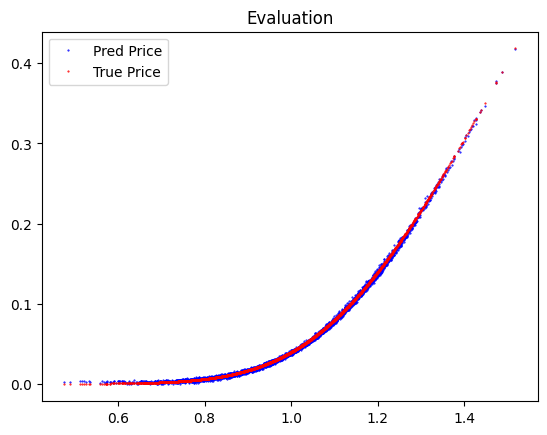

RMSE 0.003052718471735716


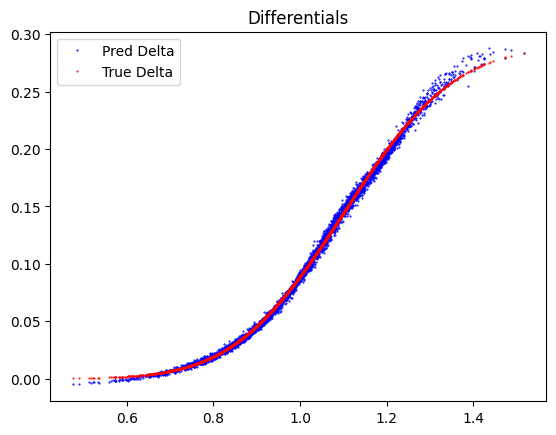

In [102]:
pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x_test)

pred_y = pred_y[:, jnp.newaxis]
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(baskets, pred_y, 'b.', markersize=1)
plt.plot(baskets, y_test, 'r.', markersize=1)
plt.legend(['Pred Price', 'True Price'], loc='upper left')
plt.show()


deltas_rmse = eval_rmse(dydx_test, pred_dydx)
print(f"RMSE {deltas_rmse}")

plt.title("Differentials")
dydx_idx = 0
plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
plt.show()